In [1]:
# Cellule 1 : Préparation de l'Environnement et Imports

# --- Bibliothèques standards et pour le calcul ---
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- Bibliothèques pour le traitement de données et d'images ---
import pandas as pd
import cv2  # OpenCV

# --- Bibliothèques pour le Machine Learning et la Métrique ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Bibliothèques pour l'interaction avec Google Colab ---
from google.colab import files

print("✅ Environnement prêt. Toutes les bibliothèques sont importées.")

✅ Environnement prêt. Toutes les bibliothèques sont importées.


In [2]:
# Cellule 2 : Connexion à Kaggle et Téléchargement des Données

# --- Installation de la librairie Kaggle ---
!pip install kaggle --quiet

# --- Authentification via le fichier kaggle.json ---
print("Veuillez uploader votre fichier kaggle.json")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("\nFichier kaggle.json uploadé avec succès.")

    # Configuration du chemin pour l'API Kaggle
    if not os.path.exists('/root/.kaggle'):
        os.makedirs('/root/.kaggle')
    os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)

    # --- Téléchargement et décompression du jeu de données ---
    print("Téléchargement du jeu de données AMHCD...")
    !kaggle datasets download -d benaddym/amazigh-handwritten-character-database-amhcd -p /content/data --unzip --quiet
    print("✅ Jeu de données téléchargé et décompressé dans /content/data/")

else:
    print("\n⚠️ Erreur : Le fichier kaggle.json n'a pas été trouvé.")

# Vérification du contenu (optionnel)
print("\nContenu du dossier de données :")
!ls /content/data

Veuillez uploader votre fichier kaggle.json


Saving kaggle.json to kaggle.json

Fichier kaggle.json uploadé avec succès.
Téléchargement du jeu de données AMHCD...
Dataset URL: https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
License(s): other
✅ Jeu de données téléchargé et décompressé dans /content/data/

Contenu du dossier de données :
amhcd_64  AMHCD_64  labels


In [8]:
# Cellule 3 : Chargement et Prétraitement des Données (Version Finale Corrigée)

def load_data_from_folders(root_path):
    """
    Charge les données d'images depuis une structure de dossiers où chaque
    sous-dossier représente une classe. Sépare ensuite les données en
    ensembles d'entraînement et de test.
    """
    print(f"\nDébut du chargement des images depuis : {root_path}")
    images = []
    labels_int = []

    class_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    if not class_names:
        raise ValueError(f"ERREUR : Aucun dossier de classe trouvé dans '{root_path}'.")

    label_to_int = {name: i for i, name in enumerate(class_names)}
    print(f"{len(class_names)} classes trouvées.")

    for class_name in class_names:
        class_path = os.path.join(root_path, class_name)
        for image_file in os.listdir(class_path):
            if image_file.endswith('.jpeg'):
                img_path = os.path.join(class_path, image_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (32, 32))
                    images.append(img_resized)
                    labels_int.append(label_to_int[class_name])

    images = np.array(images, dtype='float32') / 255.0
    labels_int = np.array(labels_int)

    # --- LA CORRECTION EST ICI ---
    # Nous mettons la dimension du canal en deuxième position (axis=1)
    # pour avoir un format (N, C, H, W) -> (batch, canaux, hauteur, largeur)
    images = np.expand_dims(images, axis=1)

    print(f"Total de {len(images)} images chargées.")
    print("Séparation des données en ensembles d'entraînement (80%) et de test (20%)...")

    x_train, x_test, y_train_int, y_test_labels = train_test_split(
        images, labels_int, test_size=0.20, random_state=42, stratify=labels_int
    )

    num_classes = len(class_names)
    y_train = np.eye(num_classes)[y_train_int]
    y_test = np.eye(num_classes)[y_test_labels]

    return x_train, y_train, x_test, y_test, y_test_labels, class_names

# --- Lancement du chargement ---
try:
    data_root_folder = '/content/data/AMHCD_64/AMHCD_64/'
    x_train, y_train, x_test, y_test, y_test_labels, class_names = load_data_from_folders(root_path=data_root_folder)

    print("\n--- ✅ Préparation des données terminée ---")
    print(f"Format des données d'entraînement (images):\t{x_train.shape}")
    print(f"Format des données d'entraînement (labels):\t{y_train.shape}")
    print(f"Format des données de test (images):\t\t{x_test.shape}")
    print(f"Format des données de test (labels):\t\t{y_test.shape}")
    print(f"Nombre de classes détectées:\t\t{len(class_names)}")
except Exception as e:
    print(f"\n⚠️ Une erreur est survenue : {e}")


Début du chargement des images depuis : /content/data/AMHCD_64/AMHCD_64/
33 classes trouvées.
Total de 25740 images chargées.
Séparation des données en ensembles d'entraînement (80%) et de test (20%)...

--- ✅ Préparation des données terminée ---
Format des données d'entraînement (images):	(20592, 1, 32, 32)
Format des données d'entraînement (labels):	(20592, 33)
Format des données de test (images):		(5148, 1, 32, 32)
Format des données de test (labels):		(5148, 33)
Nombre de classes détectées:		33


In [9]:
# Cellule 4 : Définition des Couches du Réseau "From Scratch"

class Tanh:
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    def backward(self, grad):
        return grad * (1 - self.y**2)

class Softmax:
    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.y = exps / np.sum(exps, axis=-1, keepdims=True)
        return self.y
    def backward(self, grad):
        return grad

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2. / (in_channels * kernel_size**2))
        self.biases = np.zeros((1, out_channels, 1, 1))

    def forward(self, x):
        self.x = x
        n, _, h_in, w_in = x.shape
        h_out = (h_in - self.kernel_size) // self.stride + 1
        w_out = (w_in - self.kernel_size) // self.stride + 1
        self.out = np.zeros((n, self.out_channels, h_out, w_out))
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                patch = x[:, :, h_start:h_end, w_start:w_end]
                for k in range(self.out_channels):
                    self.out[:, k, i, j] = np.sum(patch * self.weights[k, ...], axis=(1, 2, 3))
        return self.out + self.biases

    def backward(self, grad_out):
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.sum(grad_out, axis=(0, 2, 3)).reshape(self.biases.shape)
        grad_x = np.zeros_like(self.x)
        _, _, h_out, w_out = grad_out.shape
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                for k in range(self.out_channels):
                    self.grad_weights[k, ...] += np.sum(self.x[:, :, h_start:h_end, w_start:w_end] * grad_out[:, k, i, j][:, np.newaxis, np.newaxis, np.newaxis], axis=0)
                for n in range(self.x.shape[0]):
                    grad_x[n, :, h_start:h_end, w_start:w_end] += np.sum(self.weights * grad_out[n, :, i, j][:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        return grad_x

class AvgPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        n, c, h_in, w_in = x.shape
        h_out = h_in // self.stride
        w_out = w_in // self.stride
        out = np.zeros((n, c, h_out, w_out))
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                patch = x[:, :, h_start:h_end, w_start:w_end]
                out[:, :, i, j] = np.mean(patch, axis=(2, 3))
        return out

    def backward(self, grad_out):
        grad_x = np.zeros_like(self.x)
        _, _, h_out, w_out = grad_out.shape
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                grad_val = grad_out[:, :, i, j][:, :, np.newaxis, np.newaxis]
                grad_x[:, :, h_start:h_end, w_start:w_end] += grad_val / (self.kernel_size * self.kernel_size)
        return grad_x

class Flatten:
    def forward(self, x):
        self.x_shape = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, grad):
        return grad.reshape(self.x_shape)

class Dense:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.biases = np.zeros(out_features)

    def forward(self, x):
        self.x = x
        return x @ self.weights + self.biases

    def backward(self, grad_out):
        self.grad_weights = self.x.T @ grad_out
        self.grad_biases = np.sum(grad_out, axis=0)
        return grad_out @ self.weights.T

print("✅ Briques de base (Couches & Activations) définies.")

✅ Briques de base (Couches & Activations) définies.


In [10]:
# Cellule 5 : Définition de l'Architecture LeNet-5

class LeNet5_Tifinagh:
    def __init__(self, num_classes=33):
        self.c1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5)
        self.tanh1 = Tanh()
        self.s2 = AvgPool2D(kernel_size=2, stride=2)
        self.tanh2 = Tanh()
        self.c3 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.tanh3 = Tanh()
        self.s4 = AvgPool2D(kernel_size=2, stride=2)
        self.tanh4 = Tanh()
        self.flatten = Flatten()
        self.c5 = Dense(in_features=16*5*5, out_features=120)
        self.tanh5 = Tanh()
        self.f6 = Dense(in_features=120, out_features=84)
        self.tanh6 = Tanh()
        self.output = Dense(in_features=84, out_features=num_classes)
        self.softmax = Softmax()

        self.layers_with_params = [self.c1, self.c3, self.c5, self.f6, self.output]

    def forward(self, x):
        out = self.c1.forward(x)
        out = self.tanh1.forward(out)
        out = self.s2.forward(out)
        out = self.tanh2.forward(out)
        out = self.c3.forward(out)
        out = self.tanh3.forward(out)
        out = self.s4.forward(out)
        out = self.tanh4.forward(out)
        out = self.flatten.forward(out)
        out = self.c5.forward(out)
        out = self.tanh5.forward(out)
        out = self.f6.forward(out)
        out = self.tanh6.forward(out)
        out = self.output.forward(out)
        out = self.softmax.forward(out)
        return out

    def backward(self, grad):
        grad = self.softmax.backward(grad)
        grad = self.output.backward(grad)
        grad = self.tanh6.backward(grad)
        grad = self.f6.backward(grad)
        grad = self.tanh5.backward(grad)
        grad = self.c5.backward(grad)
        grad = self.flatten.backward(grad)
        grad = self.tanh4.backward(grad)
        grad = self.s4.backward(grad)
        grad = self.tanh3.backward(grad)
        grad = self.c3.backward(grad)
        grad = self.tanh2.backward(grad)
        grad = self.s2.backward(grad)
        grad = self.tanh1.backward(grad)
        grad = self.c1.backward(grad)

print("✅ Architecture LeNet-5 définie.")

✅ Architecture LeNet-5 définie.


In [11]:
# Cellule 6 : Fonctions d'Apprentissage (Perte, Optimiseur, Boucle)

def categorical_cross_entropy(y_pred, y_true):
    y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    grad = (y_pred - y_true) / y_pred.shape[0]
    return loss, grad

class SGD:
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate

    def update(self, layers):
        for layer in layers:
            if hasattr(layer, 'weights'):
                layer.weights -= self.lr * layer.grad_weights
                layer.biases -= self.lr * layer.grad_biases

def train(model, x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate):
    optimizer = SGD(learning_rate=learning_rate)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        epoch_start_time = time.time()

        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            y_pred = model.forward(x_batch)
            loss, grad = categorical_cross_entropy(y_pred, y_batch)
            model.backward(grad)
            optimizer.update(model.layers_with_params)

        # Évaluation à la fin de chaque époque
        train_pred = model.forward(x_train)
        train_loss, _ = categorical_cross_entropy(train_pred, y_train)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == np.argmax(y_train, axis=1))

        val_pred = model.forward(x_test)
        val_loss, _ = categorical_cross_entropy(val_pred, y_test)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_test, axis=1))

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    return history

print("✅ Fonctions d'apprentissage prêtes.")

✅ Fonctions d'apprentissage prêtes.


In [13]:
# Cellule 7 : Configuration et Lancement de l'Entraînement

# --- 1. Instanciation du Modèle ---
# Nous créons une nouvelle instance de notre architecture LeNet-5.
# Le nombre de classes est déterminé automatiquement à partir des données chargées.
model = LeNet5_Tifinagh(num_classes=len(class_names))


# --- 2. Configuration des Hyperparamètres de l'Apprentissage ---
# Ce sont les réglages principaux qui vont influencer la qualité et la vitesse de l'apprentissage.
EPOCHS = 10          # Nombre total de fois où le modèle verra l'ensemble des données.
BATCH_SIZE = 64      # Nombre d'images traitées en même temps à chaque étape.
LEARNING_RATE = 0.1  # "Vitesse" à laquelle le modèle ajuste ses poids.

print("--- CONFIGURATION DE L'ENTRAÎNEMENT ---")
print(f"Modèle LeNet-5 initialisé pour {len(class_names)} classes.")
print(f"   - Nombre d'époques: {EPOCHS}")
print(f"   - Taille des lots (batch size): {BATCH_SIZE}")
print(f"   - Taux d'apprentissage (learning rate): {LEARNING_RATE}")
print("---------------------------------------")


# --- 3. Lancement de la Boucle d'Entraînement ---
# La fonction train() va maintenant s'exécuter.
# La progression sera affichée pour chaque époque ci-dessous.
print("\n▶️ Lancement de l'entraînement...")

history = train(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE
)

print("\n--- ✅ ENTRAÎNEMENT TERMINÉ ! ---")


# --- 4. Résumé des Meilleures Performances ---
# On recherche la meilleure précision obtenue sur l'ensemble de validation.
best_epoch_index = np.argmax(history['val_accuracy'])
best_val_acc = history['val_accuracy'][best_epoch_index]
corresponding_train_acc = history['accuracy'][best_epoch_index]

print("\n--- MEILLEURS RÉSULTATS ---")
print(f"Meilleure précision de validation : {best_val_acc:.4f} (obtenue à l'époque n°{best_epoch_index + 1})")
print(f"Précision d'entraînement à cette époque : {corresponding_train_acc:.4f}")
print("---------------------------")

--- CONFIGURATION DE L'ENTRAÎNEMENT ---
Modèle LeNet-5 initialisé pour 33 classes.
   - Nombre d'époques: 10
   - Taille des lots (batch size): 64
   - Taux d'apprentissage (learning rate): 0.1
---------------------------------------

▶️ Lancement de l'entraînement...
Epoch 1/10 - 519.6s - loss: 1.0421 - acc: 0.7825 - val_loss: 1.0590 - val_acc: 0.7756
Epoch 2/10 - 519.3s - loss: 0.5002 - acc: 0.8805 - val_loss: 0.5336 - val_acc: 0.8675
Epoch 3/10 - 537.4s - loss: 0.2991 - acc: 0.9288 - val_loss: 0.3424 - val_acc: 0.9176
Epoch 4/10 - 529.5s - loss: 0.2222 - acc: 0.9467 - val_loss: 0.2714 - val_acc: 0.9307
Epoch 5/10 - 528.9s - loss: 0.1694 - acc: 0.9595 - val_loss: 0.2194 - val_acc: 0.9423
Epoch 6/10 - 528.9s - loss: 0.1623 - acc: 0.9604 - val_loss: 0.2144 - val_acc: 0.9419
Epoch 7/10 - 535.0s - loss: 0.1527 - acc: 0.9667 - val_loss: 0.2059 - val_acc: 0.9464
Epoch 8/10 - 520.4s - loss: 0.0934 - acc: 0.9788 - val_loss: 0.1482 - val_acc: 0.9577
Epoch 9/10 - 525.8s - loss: 0.0829 - acc: 0


Affichage des courbes d'apprentissage...


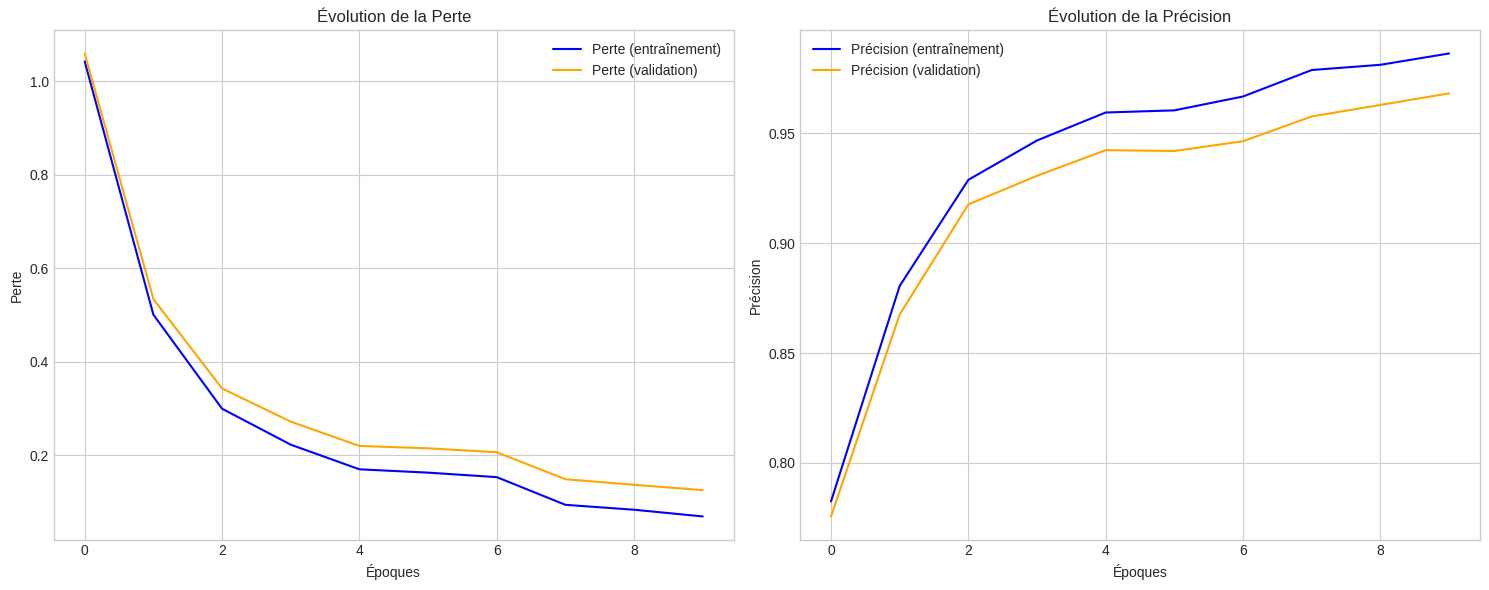


Calcul et affichage de la matrice de confusion...


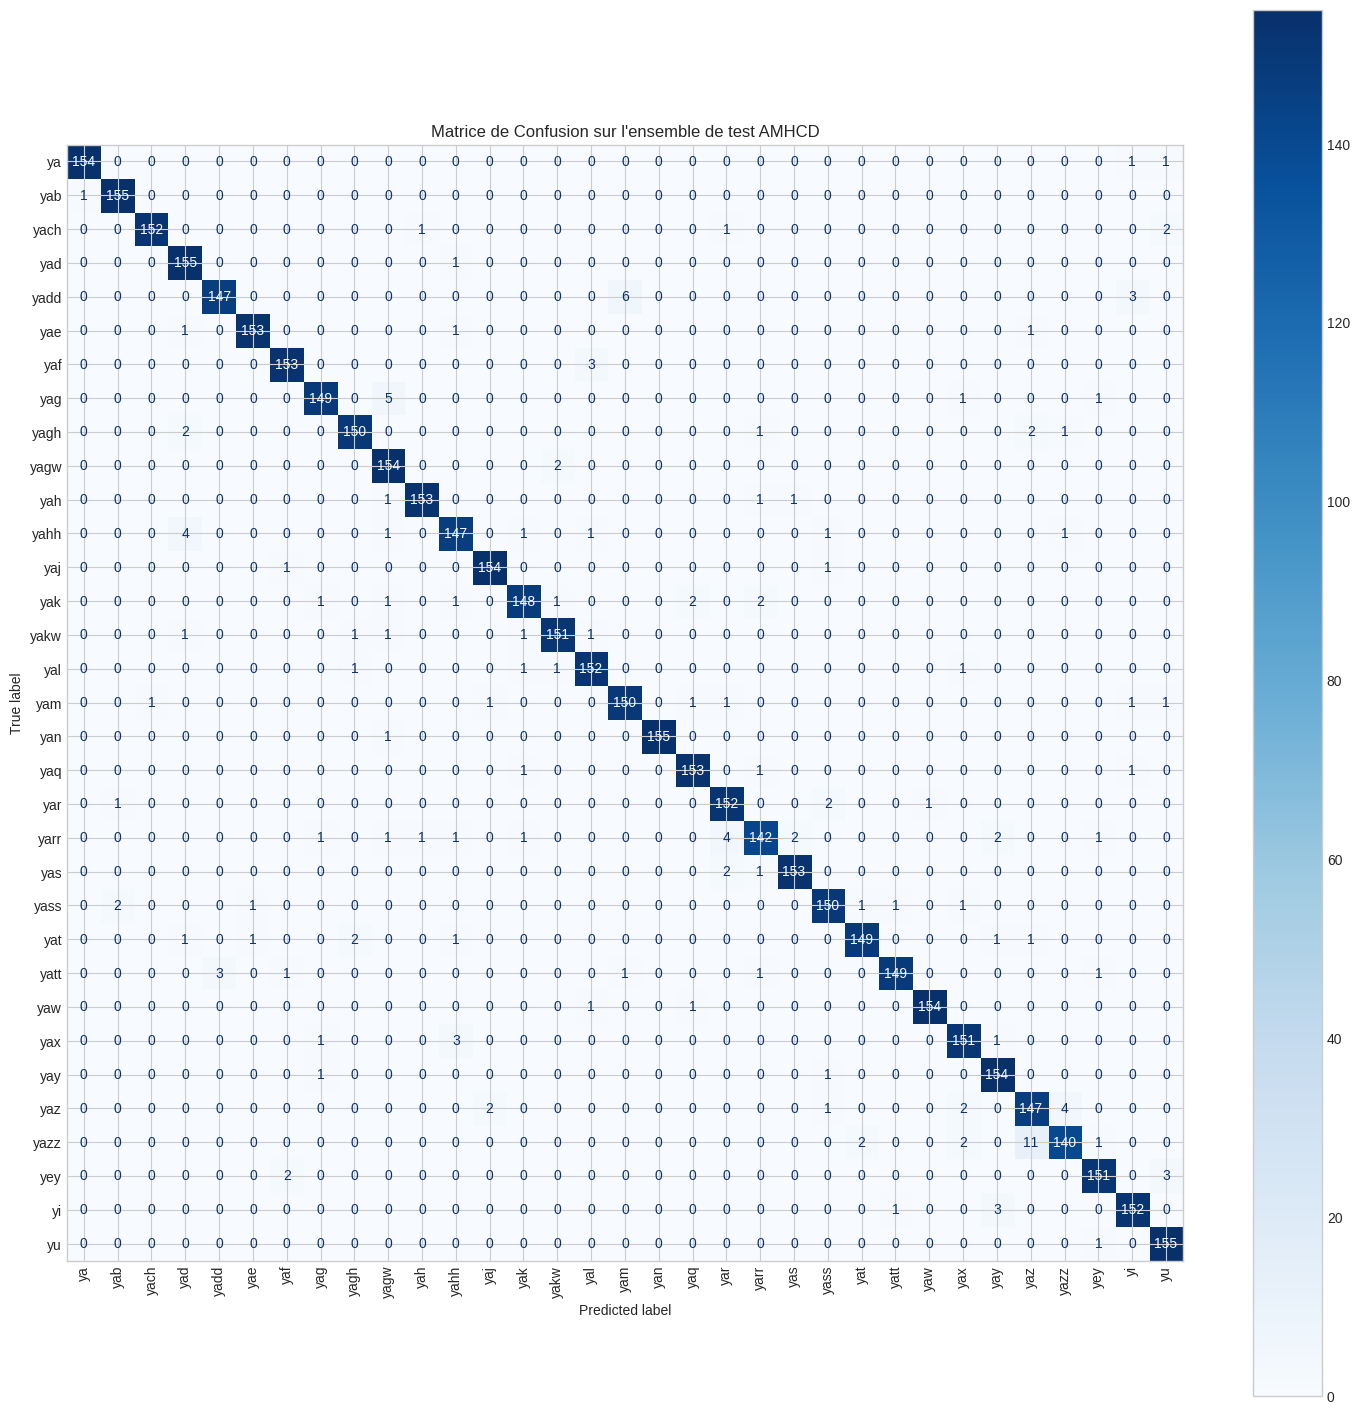

In [14]:
# Cellule 8 : Visualisation des Performances

def plot_history(history):
    """Affiche les courbes de perte et de précision."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 6))

    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Perte (entraînement)', color='blue')
    plt.plot(history['val_loss'], label='Perte (validation)', color='orange')
    plt.title('Évolution de la Perte')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    # Courbe de précision
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Précision (entraînement)', color='blue')
    plt.plot(history['val_accuracy'], label='Précision (validation)', color='orange')
    plt.title('Évolution de la Précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Afficher les courbes ---
print("\nAffichage des courbes d'apprentissage...")
plot_history(history)

# --- Afficher la matrice de confusion ---
print("\nCalcul et affichage de la matrice de confusion...")
y_pred_test = model.forward(x_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(18, 18))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Matrice de Confusion sur l\'ensemble de test AMHCD')
plt.show()